In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import utils
from whitelists import *
from sorted_crates import *
from top_crates import *
import functools

# Configure pyplot: enlarge plots 
plt.rcParams['figure.figsize'] = [15, 8]
# Configure pandas: show all columns when printing a dataframe
pd.set_option('display.max_columns', None)
# Configure pandas: show more rows when printing a dataframe
pd.set_option('display.min_rows', 20)

In [2]:
# Load tables
function_definitions = utils.load_selected_function_definitions()
raw_function_unsafe_reasons = utils.load_unsafe_reasons_in_function_definitions()
unsafe_block_calls = utils.load_unsafe_block_calls()
const_calls = utils.load_const_calls()
unsafe_blocks = utils.load_unsafe_blocks()
traits = utils.load_selected_traits()
traits_impls = utils.load_selected_impl_definitions()
type_defs = utils.load_selected_type_defs()
adts = utils.load_selected_adts()
adt_field_types = utils.load_selected_adt_field_types()
selected_builds = utils.load_selected_builds()

In [3]:
# Cleanup: remove duplicates
raw_function_unsafe_reasons = raw_function_unsafe_reasons.drop_duplicates()

# Remove functions that are not in function_definitions
raw_function_unsafe_reasons = raw_function_unsafe_reasons[
    raw_function_unsafe_reasons.def_path.isin(set(function_definitions.def_path.unique()))
]

possible_unsafe_reasons = [
    "call to unsafe function",
    "use of inline assembly",
    "initializing type with `rustc_layout_scalar_valid_range` attr",
    "cast of pointer to int",
    "pointer operation",
    "borrow of packed field",
    "use of mutable static",
    "use of extern static",
    "dereference of raw pointer",
    "assignment to non-`Copy` union field",
    "access to union field",
    "mutation of layout constrained field",
    "borrow of layout constrained field with interior mutability",
]

# Map reasons -> number
function_unsafe_reasons = raw_function_unsafe_reasons[
    ["crate_name", "crate_hash", "def_path", "unsafe_reason"]
].groupby("def_path").agg(frozenset).rename(
    columns={'unsafe_reason': 'unsafe_reasons'}
)

function_unsafe_reasons["unsafe_reasons_vec"] = function_unsafe_reasons.unsafe_reasons.map(
    lambda x: [reason in x for reason in possible_unsafe_reasons]
)
function_unsafe_reasons["num_unsafe_reasons"] = function_unsafe_reasons.unsafe_reasons_vec.map(sum)

for reason in possible_unsafe_reasons:
    function_unsafe_reasons[reason] = function_unsafe_reasons.unsafe_reasons.map(
        lambda x: reason in x
    )

# Augment const calls made from unsafe blocks
unsafe_block_const_calls = unsafe_block_calls.join(
    const_calls.set_index("call"),
    on="call",
    how="inner",
    rsuffix="_defsite",
)
# Rename confusing columns
unsafe_block_const_calls.rename(
    columns={"crate_name": "crate_callsite", "crate": "crate_defsite"},
    inplace=True
)
const_calls.rename(
    columns={"crate_name": "crate_callsite", "crate": "crate_defsite"},
    inplace=True
)

# Preprocessing
crates = pd.DataFrame({
    "crate": selected_builds.crate,
    "crate_hash": selected_builds.crate_hash,
    "package": selected_builds.package.map(lambda x: str(x).lower().replace("-", "_")),
})
user_written_unsafe_blocks = unsafe_blocks[unsafe_blocks.check_mode == "UnsafeBlockUserProvided"]
unsafe_function_definitions = function_definitions[function_definitions.unsafety == "Unsafe"]
unsafe_traits = traits[traits.unsafety == "Unsafe"]
unsafe_traits_impls = traits_impls[traits_impls.unsafety == "Unsafe"]

In [4]:
# Whitelists
all_function_names = set(function_definitions.def_path.unique())
unchecked_function_names = get_unchecked_function_names(all_function_names)
unguarded_function_names = get_unguarded_function_names(all_function_names)

In [5]:
# Calls
all_calls = utils.load_all_calls()
unsafe_calls = all_calls.query("unsafety != 'Normal'")
assert len(pd.unique(unsafe_calls.unsafety)) == 1

In [6]:
# Top X Crates
def norm(x):
    return x.lower().replace("-", "_")

top_250_compiling_crates = set(map(norm, sorted_crates[:250])) & set(map(norm, selected_builds.package.unique()))
top_250_crates_set = set(sorted_crates[:250])
top_250_mask = selected_builds.package.map(lambda x: x.replace("-", "_") in top_250_crates_set)
top_250_builds = selected_builds[top_250_mask][
    ~selected_builds[top_250_mask]["package"].duplicated()
]
top_500_compiling_crates = set(map(norm, sorted_crates[:500])) & set(map(norm, selected_builds.package.unique()))
top_500_crates_set = set(sorted_crates[:500])
top_500_mask = selected_builds.package.map(lambda x: x.replace("-", "_") in top_500_crates_set)
top_500_builds = selected_builds[top_500_mask][
    ~selected_builds[top_500_mask]["package"].duplicated()
]
top_1000_compiling_crates = set(map(norm, sorted_crates[:1000])) & set(map(norm, selected_builds.package.unique()))
top_1000_crates_set = set(sorted_crates[:1000])
top_1000_mask = selected_builds.package.map(lambda x: x.replace("-", "_") in top_1000_crates_set)
top_1000_builds = selected_builds[top_1000_mask][
    ~selected_builds[top_1000_mask]["package"].duplicated()
]

In [7]:
print("Number of compiling crates in top 250:\t", len(top_250_compiling_crates))
print("Number of builds in top 250:\t\t", len(top_250_builds))
print("Number of expected crates in top 250:\t", len(sorted_crates[:250]))

Number of compiling crates in top 250:	 248
Number of builds in top 250:		 248
Number of expected crates in top 250:	 250


In [8]:
print("Number of compiling crates in top 500:\t", len(top_500_compiling_crates))
print("Number of builds in top 500:\t\t", len(top_500_builds))
print("Number of expected crates in top 500:\t", len(sorted_crates[:500]))

Number of compiling crates in top 500:	 480
Number of builds in top 500:		 480
Number of expected crates in top 500:	 500


In [9]:
print("Number of compiling crates in top 1000:\t", len(top_1000_compiling_crates))
print("Number of builds in top 1000:\t\t", len(top_1000_builds))
print("Number of expected crates in top 1000:\t", len(sorted_crates[:1000]))

Number of compiling crates in top 1000:	 488
Number of builds in top 1000:		 488
Number of expected crates in top 1000:	 1000


In [10]:
print("Number of selected builds:\t", len(selected_builds))
print("Number of crates total:\t\t", len(crates))

Number of selected builds:	 510
Number of crates total:		 510


ForeignItem    3478
Rust           2699
C               176
Name: abi, dtype: int64
ForeignItem    54.745789
Rust           42.483866
C               2.770345
Name: abi, dtype: float64
Unsafe function definitions: 6353


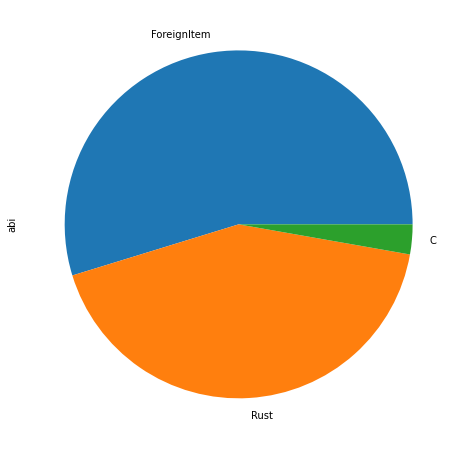

In [11]:
# Frequency of abi DEFINITIONS - FIXME (add rest)
values = unsafe_function_definitions.abi.value_counts()
print(values)
print(values / len(unsafe_function_definitions) * 100)
print("Unsafe function definitions:", len(unsafe_function_definitions))
values.plot.pie()
del values

In [12]:
# Which crates define unsafe Rust functions?
def_unsafe_rust_funcs = unsafe_function_definitions[
    unsafe_function_definitions.abi == "Rust"
]

print("------top 250------")
def_urust = def_unsafe_rust_funcs[
    def_unsafe_rust_funcs.crate.isin(sorted_crates[:250])
]
values = def_urust.crate.value_counts()
print("Number of crates that define unsafe Rust functions:\t", len(values))
print("Names and counts of 20 crates with most defined unsafe Rust functions:")
print()
print(values[:20])
del values, def_urust

print("------top 500------")
def_urust = def_unsafe_rust_funcs[
    def_unsafe_rust_funcs.crate.isin(sorted_crates[:500])
]
values = def_urust.crate.value_counts()
print("Number of crates that define unsafe Rust functions:\t", len(values))
print("Names and counts of 20 crates with most defined unsafe Rust functions:")
print()
print(values[:20])
del values, def_urust

print("------top 1000------")
def_urust = def_unsafe_rust_funcs[
    def_unsafe_rust_funcs.crate.isin(sorted_crates[:1000])
]
values = def_urust.crate.value_counts()
print("Number of crates that define unsafe Rust functions:\t", len(values))
print("Names and counts of 20 crates with most defined unsafe Rust functions:")
print()
print(values[:20])
del values, def_urust

print("------total------")
values = def_unsafe_rust_funcs.crate.value_counts()
print("Number of crates that define unsafe Rust functions:\t", len(values))
print("Names and counts of 20 crates with most defined unsafe Rust functions:")
print()
print(values[:20])
del values

------top 250------
Number of crates that define unsafe Rust functions:	 92
Names and counts of 20 crates with most defined unsafe Rust functions:

futures_util        121
tokio                84
openssl              80
nix                  79
cloudabi             66
core_foundation      58
wasi                 45
openssl_sys          42
aho_corasick         41
hashbrown            34
bytes                33
rayon_core           33
crossbeam_epoch      28
parking_lot          27
memchr               26
ppv_lite86           25
hyper                25
lock_api             23
parking_lot_core     21
encoding_rs          20
Name: crate, dtype: int64
------top 500------
Number of crates that define unsafe Rust functions:	 145
Names and counts of 20 crates with most defined unsafe Rust functions:

js_sys             803
futures_util       121
git2               108
tokio               84
openssl             80
nix                 79
blake2b_simd        77
wasm_bindgen        70
cloudabi     

In [13]:
# Which crates define C functions?
def_c_funcs = unsafe_function_definitions[
    unsafe_function_definitions.abi == "C"
]
values = def_c_funcs.crate.value_counts()

print("------top 250------")
def_c = def_c_funcs[
    def_c_funcs.crate.isin(sorted_crates[:250])
]
vals = def_c.crate.value_counts()
print("Number of crates that define C functions:\t", len(vals))
print("Names and counts:")
print()
print(vals)
print()
del vals, def_c

print("------top 500------")
def_c = def_c_funcs[
    def_c_funcs.crate.isin(sorted_crates[:500])
]
vals = def_c.crate.value_counts()
print("Number of crates that define C functions:\t", len(vals))
print("Names and counts:")
print()
print(vals)
print()
del vals, def_c

print("------top 1000------")
def_c = def_c_funcs[
    def_c_funcs.crate.isin(sorted_crates[:1000])
]
vals = def_c.crate.value_counts()
print("Number of crates that define C functions:\t", len(vals))
print("Names and counts:")
print()
print(vals)
print()
del vals, def_c

print("------total------")
print("Number of crates that define C functions:\t", len(values))
print("Names and counts:")
print()
print(values)
del values

------top 250------
Number of crates that define C functions:	 4
Names and counts:

libc         27
openssl      18
backtrace     1
ring          1
Name: crate, dtype: int64

------top 500------
Number of crates that define C functions:	 7
Names and counts:

wasm_bindgen          96
miniz_oxide_c_api     31
libc                  27
openssl               18
security_framework     2
ring                   1
backtrace              1
Name: crate, dtype: int64

------top 1000------
Number of crates that define C functions:	 7
Names and counts:

wasm_bindgen          96
miniz_oxide_c_api     31
libc                  27
openssl               18
security_framework     2
ring                   1
backtrace              1
Name: crate, dtype: int64

------total------
Number of crates that define C functions:	 7
Names and counts:

wasm_bindgen          96
miniz_oxide_c_api     31
libc                  27
openssl               18
security_framework     2
ring                   1
backtrace           

In [14]:
# Which crates define Foreign Items?
def_fi_funcs = unsafe_function_definitions[
    unsafe_function_definitions.abi == "ForeignItem"
]
values = def_fi_funcs.crate.value_counts()

print("------top 250------")
def_fi = def_fi_funcs[
    def_fi_funcs.crate.isin(sorted_crates[:250])
]
vals = def_fi.crate.value_counts()
print("Number of crates that define Foreign Items:\t", len(vals))
print("Names and counts of 20 crates with most defined Foreign Items:")
print()
print(vals[:20])
print()
del vals, def_fi

print("------top 500------")
def_fi = def_fi_funcs[
    def_fi_funcs.crate.isin(sorted_crates[:500])
]
vals = def_fi.crate.value_counts()
print("Number of crates that define Foreign Items:\t", len(vals))
print("Names and counts of 20 crates with most defined Foreign Items:")
print()
print(vals[:20])
print()
del vals, def_fi

print("------top 1000------")
def_fi = def_fi_funcs[
    def_fi_funcs.crate.isin(sorted_crates[:1000])
]
vals = def_fi.crate.value_counts()
print("Number of crates that define Foreign Items:\t", len(vals))
print("Names and counts of 20 crates with most defined Foreign Items:")
print()
print(vals[:20])
print()
del vals, def_fi

print("------total------")
print("Number of crates that define Foreign Items:\t", len(values))
print("Names and counts of 20 crates with most defined Foreign Items:")
print()
print(values[:20])
# crypto sneaks in here again
del values

------top 250------
Number of crates that define Foreign Items:	 10
Names and counts of 20 crates with most defined Foreign Items:

openssl_sys            733
libc                   702
core_foundation_sys    230
ring                    74
libz_sys                56
cloudabi                49
wasi                    45
backtrace                4
backtrace_sys            3
time                     1
Name: crate, dtype: int64

------top 500------
Number of crates that define Foreign Items:	 30
Names and counts of 20 crates with most defined Foreign Items:

openssl_sys               733
libc                      702
libgit2_sys               593
clang_sys                 288
core_foundation_sys       230
libsqlite3_sys            174
fuchsia_zircon_sys        139
libssh2_sys                96
ring                       74
security_framework_sys     57
libz_sys                   56
hermit_abi                 55
lzma_sys                   52
cloudabi                   49
wasi               

------top 250------
Rust              4319
C                 1409
rust-intrinsic     259
Name: abi, dtype: int64

Percents: 
Rust              72.139636
C                 23.534324
rust-intrinsic     4.326040
Name: abi, dtype: float64

Unsafe calls: 5987


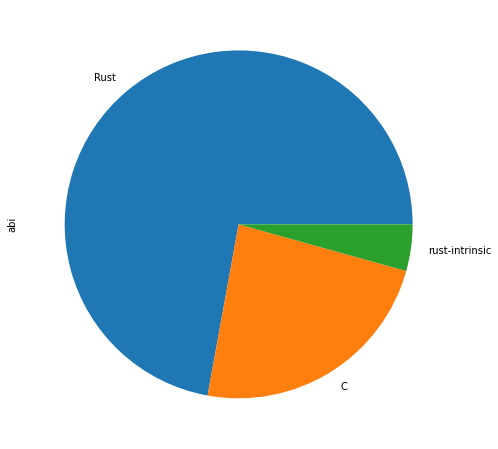

In [15]:
# Frequency of abi CALLS
unsafe_const_calls = const_calls[
    const_calls.unsafety == "Unsafe"
]
unsafe_const_calls_250 = unsafe_const_calls[
    unsafe_const_calls.crate_callsite.isin(sorted_crates[:250])
]
values_250 = unsafe_const_calls_250.abi.value_counts()

print("------top 250------")
print(values_250)
print()
print("Percents: ")
print(values_250 / len(unsafe_const_calls_250) * 100)
print()
print("Unsafe calls:", len(unsafe_const_calls_250))
values_250.plot.pie()

del values_250

------top 500------
Rust              7739
C                 2213
rust-intrinsic     544
Name: abi, dtype: int64

Percents: 
Rust              73.732851
C                 21.084223
rust-intrinsic     5.182927
Name: abi, dtype: float64

Unsafe calls: 10496


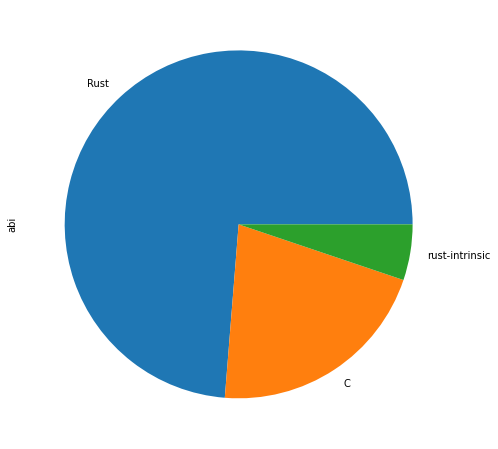

In [16]:
unsafe_const_calls_500 = unsafe_const_calls[
    unsafe_const_calls.crate_callsite.isin(sorted_crates[:500])
]
values_500 = unsafe_const_calls_500.abi.value_counts()

print("------top 500------")
print(values_500)
print()
print("Percents: ")
print(values_500 / len(unsafe_const_calls_500) * 100)
print()
print("Unsafe calls:", len(unsafe_const_calls_500))
values_500.plot.pie()

del values_500

------top 1000------
Rust              7767
C                 2231
rust-intrinsic     638
Name: abi, dtype: int64

Percents: 
Rust              73.025574
C                 20.975931
rust-intrinsic     5.998496
Name: abi, dtype: float64

Unsafe calls: 10636


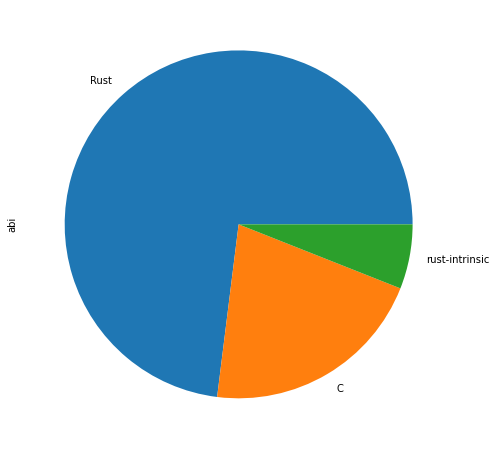

In [17]:
unsafe_const_calls_1000 = unsafe_const_calls[
    unsafe_const_calls.crate_callsite.isin(sorted_crates[:1000])
]
values_1000 = unsafe_const_calls_1000.abi.value_counts()

print("------top 1000------")
print(values_1000)
print()
print("Percents: ")
print(values_1000 / len(unsafe_const_calls_1000) * 100)
print()
print("Unsafe calls:", len(unsafe_const_calls_1000))
values_1000.plot.pie()

del values_1000

------total------
Rust              7844
C                 2242
rust-intrinsic     644
Name: abi, dtype: int64

Percents: 
Rust              73.103448
C                 20.894688
rust-intrinsic     6.001864
Name: abi, dtype: float64

Unsafe calls: 10730


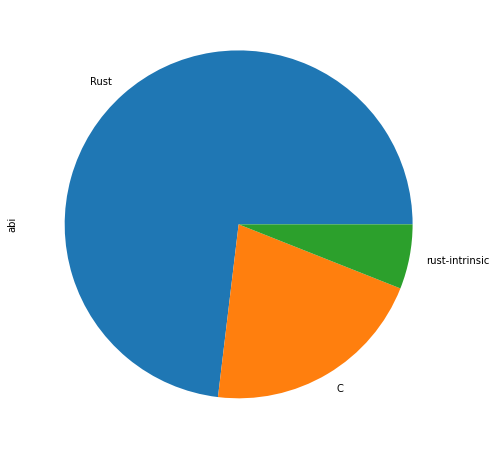

In [18]:
# Frequency of abi CALLS
values = unsafe_const_calls.abi.value_counts()

print("------total------")
print(values)
print()
print("Percents: ")
print(values / len(unsafe_const_calls) * 100)
print()
print("Unsafe calls:", len(unsafe_const_calls))
values.plot.pie()

del values

In [19]:
# Which crates call unsafe Rust functions? - ALL
calls_unsafe_rust_funcs = unsafe_const_calls[
    unsafe_const_calls.abi == "Rust"
]
values = calls_unsafe_rust_funcs.crate_defsite.value_counts()

# Filter by user-written blocks
uw_calls_unsafe_rust_funcs = calls_unsafe_rust_funcs[
    calls_unsafe_rust_funcs.check_mode == "UnsafeBlockUserProvided"
]
values_uw = uw_calls_unsafe_rust_funcs.crate_defsite.value_counts()

assert(len(values) == len(values_uw))
del values

print("------top 250------")
uw_urust = uw_calls_unsafe_rust_funcs[
    uw_calls_unsafe_rust_funcs.crate_callsite.isin(sorted_crates[:250])
]
values = uw_urust.crate_defsite.value_counts()
print("Number of crates that call unsafe Rust:\t", len(values))
print("Top 20 crates with most unsafe Rust calls:\t")
print()
print(values[:20])
print()
del values

print("------top 500------")
uw_urust = uw_calls_unsafe_rust_funcs[
    uw_calls_unsafe_rust_funcs.crate_callsite.isin(sorted_crates[:500])
]
values = uw_urust.crate_defsite.value_counts()
print("Number of crates that call unsafe Rust:\t", len(values))
print("Top 20 crates with most unsafe Rust calls:\t")
print()
print(values[:20])
print()
del values

print("------top 1000------")
uw_urust = uw_calls_unsafe_rust_funcs[
    uw_calls_unsafe_rust_funcs.crate_callsite.isin(sorted_crates[:1000])
]
values = uw_urust.crate_defsite.value_counts()
print("Number of crates that call unsafe Rust:\t", len(values))
print("Top 20 crates with most unsafe Rust calls:\t")
print()
print(values[:20])
print()
del values

print("------total------")
print("Number of crates that call unsafe Rust:\t", len(values_uw))
print("Top 20 crates with most unsafe Rust calls:\t")
print()
print(values_uw[:20])
del values_uw

------top 250------
Number of crates that call unsafe Rust:	 73
Top 20 crates with most unsafe Rust calls:	

core                    2442
foreign_types_shared     207
generic_array            149
hashbrown                144
alloc                    122
std                      111
core_foundation           98
nix                       90
lock_api                  70
crossbeam_epoch           58
socket2                   53
encoding_rs               48
tokio                     46
crossbeam_deque           40
bytes                     37
openssl_sys               36
parking_lot_core          31
arrayvec                  26
openssl                   24
rayon_core                23
Name: crate_defsite, dtype: int64

------top 500------
Number of crates that call unsafe Rust:	 114
Top 20 crates with most unsafe Rust calls:	

core                    3384
js_sys                   691
wasm_bindgen             581
git2                     318
combine                  210
foreign_types_shared 

In [20]:
# Which crates call C functions?
calls_c_funcs = unsafe_const_calls[
    unsafe_const_calls.abi == "C"
]

print("------top 250------")
calls_c = calls_c_funcs[
    calls_c_funcs.crate_callsite.isin(sorted_crates[:250])
]
values = calls_c.crate_defsite.value_counts()
print("Number of crates that call C functions:\t", len(values))
print("Top 20 crates with most C calls:")
print()
print(values[:20])
print()
del values

print("------top 500------")
calls_c = calls_c_funcs[
    calls_c_funcs.crate_callsite.isin(sorted_crates[:500])
]
values = calls_c.crate_defsite.value_counts()
print("Number of crates that call C functions:\t", len(values))
print("Top 20 crates with most C calls:")
print()
print(values[:20])
print()
del values

print("------top 1000------")
calls_c = calls_c_funcs[
    calls_c_funcs.crate_callsite.isin(sorted_crates[:1000])
]
values = calls_c.crate_defsite.value_counts()
print("Number of crates that call C functions:\t", len(values))
print("Top 20 crates with most C calls:")
print()
print(values[:20])
print()
del values

print("------total------")
values = calls_c_funcs.crate_defsite.value_counts()
print("Number of crates that call C functions:\t", len(values))
print("Top 20 crates with most C calls:")
print()
print(values[:20])
del values

------top 250------
Number of crates that call C functions:	 6
Top 20 crates with most C calls:

openssl_sys            748
libc                   444
core_foundation_sys    160
ring                    53
backtrace                3
time                     1
Name: crate_defsite, dtype: int64

------top 500------
Number of crates that call C functions:	 21
Top 20 crates with most C calls:

openssl_sys               748
libgit2_sys               544
libc                      501
core_foundation_sys       170
security_framework_sys     66
ring                       53
curl_sys                   47
wasm_bindgen               28
brotli_sys                 16
termios                    13
libloading                  5
bzip2_sys                   4
termion                     3
inotify_sys                 3
errno                       3
backtrace                   3
xattr                       2
libssh2_sys                 1
hermit_abi                  1
fuchsia_cprng               1
Name: cr

In [21]:
# Not included in <top 1000> b/c under "rust_crypto" in sorted_crates list ^^^; are we OK w this???
calls_c_funcs_ = calls_c_funcs[
    calls_c_funcs.crate_defsite.eq("crypto")
]
calls_c_funcs_

,build,package_name,package_version,crate_callsite,build_crate_hash,edition,crate_defsite,crate_hash,def_path,def_path_hash,summary_key,block,unsafe_scope,check_mode,call,unsafety,abi
24407,1535,rust-crypto,0.2.36,crypto,44cdc7433e3acc7d,2015,crypto,44cdc7433e3acc7d,crypto[2050]::util[0]::[0]::rust_crypto_util_s...,3d50bd13ea4c2ccdc8e54858eb9b1d7f,crypto.util..rust_crypto_util_supports_aesni,5865389,2104100,UnsafeBlockUserProvided,1747890,Unsafe,C
24410,1535,rust-crypto,0.2.36,crypto,44cdc7433e3acc7d,2015,crypto,44cdc7433e3acc7d,crypto[2050]::util[0]::[1]::rust_crypto_util_s...,2ccd79ddedaefd4cb264eee92c6b2fa2,crypto.util._1.rust_crypto_util_secure_memset,5865393,2104103,UnsafeBlockUserProvided,1747893,Unsafe,C
24413,1535,rust-crypto,0.2.36,crypto,44cdc7433e3acc7d,2015,crypto,44cdc7433e3acc7d,crypto[2050]::util[0]::[1]::rust_crypto_util_f...,31c58a304448de63b1a27958a92379a0,crypto.util._1.rust_crypto_util_fixed_time_eq_asm,5865402,2104107,UnsafeBlockUserProvided,1747899,Unsafe,C
24420,1535,rust-crypto,0.2.36,crypto,44cdc7433e3acc7d,2015,crypto,44cdc7433e3acc7d,crypto[2050]::aesni[0]::[0]::rust_crypto_aesni...,c9b2780b03f1611b9955f1a87f634de4,crypto.aesni..rust_crypto_aesni_setup_working_...,5865751,2104272,UnsafeBlockUserProvided,1747975,Unsafe,C
24424,1535,rust-crypto,0.2.36,crypto,44cdc7433e3acc7d,2015,crypto,44cdc7433e3acc7d,crypto[2050]::aesni[0]::[0]::rust_crypto_aesni...,b2cf895e155b5e6242fdad1b403cb922,crypto.aesni..rust_crypto_aesni_aesimc,5865762,2104272,UnsafeBlockUserProvided,1747979,Unsafe,C
24427,1535,rust-crypto,0.2.36,crypto,44cdc7433e3acc7d,2015,crypto,44cdc7433e3acc7d,crypto[2050]::aesni[0]::[0]::rust_crypto_aesni...,edcbdca94d87c8c06513e4a5d89a13ed,crypto.aesni..rust_crypto_aesni_setup_working_...,5865767,2104279,UnsafeBlockUserProvided,1747982,Unsafe,C
24431,1535,rust-crypto,0.2.36,crypto,44cdc7433e3acc7d,2015,crypto,44cdc7433e3acc7d,crypto[2050]::aesni[0]::[0]::rust_crypto_aesni...,b2cf895e155b5e6242fdad1b403cb922,crypto.aesni..rust_crypto_aesni_aesimc,5865778,2104279,UnsafeBlockUserProvided,1747986,Unsafe,C
24434,1535,rust-crypto,0.2.36,crypto,44cdc7433e3acc7d,2015,crypto,44cdc7433e3acc7d,crypto[2050]::aesni[0]::[0]::rust_crypto_aesni...,46e7ddefa191a0f4d832a668e4ede3f,crypto.aesni..rust_crypto_aesni_setup_working_...,5865783,2104286,UnsafeBlockUserProvided,1747989,Unsafe,C
24438,1535,rust-crypto,0.2.36,crypto,44cdc7433e3acc7d,2015,crypto,44cdc7433e3acc7d,crypto[2050]::aesni[0]::[0]::rust_crypto_aesni...,b2cf895e155b5e6242fdad1b403cb922,crypto.aesni..rust_crypto_aesni_aesimc,5865794,2104286,UnsafeBlockUserProvided,1747993,Unsafe,C
24442,1535,rust-crypto,0.2.36,crypto,44cdc7433e3acc7d,2015,crypto,44cdc7433e3acc7d,crypto[2050]::aesni[0]::[0]::rust_crypto_aesni...,e147e472c073c761f9b7a9ec39259678,crypto.aesni..rust_crypto_aesni_encrypt_block,5865800,2104293,UnsafeBlockUserProvided,1747997,Unsafe,C


In [22]:
# SIMD const calls
simd_functions = set([
    x
    for x in const_calls.def_path.unique()
    if x.startswith('core[7bab]::core_arch')
])
simd_calls = const_calls[
    const_calls.def_path.isin(simd_functions)
]

print("------top 250------")
top_simd = simd_calls[
    simd_calls.crate_callsite.isin(sorted_crates[:250])
]
simd_crates = top_simd.crate_callsite.unique()
print("Number of SIMD calls:\t\t\t", len(top_simd))
print("Number of crates that call SIMD:\t", len(simd_crates))
print("Crates that call SIMD functions:")
print(simd_crates)
print()
del top_simd, simd_crates

print("------top 500------")
top_simd = simd_calls[
    simd_calls.crate_callsite.isin(sorted_crates[:500])
]
simd_crates = top_simd.crate_callsite.unique()
print("Number of SIMD calls:\t\t\t", len(top_simd))
print("Number of crates that call SIMD:\t", len(simd_crates))
print("Crates that call SIMD functions:")
print(simd_crates)
print()
del top_simd, simd_crates

print("------top 1000------")
top_simd = simd_calls[
    simd_calls.crate_callsite.isin(sorted_crates[:1000])
]
simd_crates = top_simd.crate_callsite.unique()
print("Number of SIMD calls:\t\t\t", len(top_simd))
print("Number of crates that call SIMD:\t", len(simd_crates))
print("Crates that call SIMD functions:")
print(simd_crates)
print()
del top_simd, simd_crates

print("------total------")
simd_crates = simd_calls.crate_callsite.unique()
print("Number of SIMD calls:\t\t\t", len(simd_calls))
print("Number of crates that call SIMD (all):\t", len(simd_crates))
print("Crates that call SIMD functions (all):")
print(simd_crates)
del simd_crates

------top 250------
Number of SIMD calls:			 386
Number of crates that call SIMD:	 4
Crates that call SIMD functions:
['bstr' 'hashbrown' 'ppv_lite86' 'sha2']

------top 500------
Number of SIMD calls:			 391
Number of crates that call SIMD:	 7
Crates that call SIMD functions:
['bstr' 'hashbrown' 'ahash' 'ppv_lite86' 'sha2' 'sha1' 'rdrand']

------top 1000------
Number of SIMD calls:			 391
Number of crates that call SIMD:	 7
Crates that call SIMD functions:
['bstr' 'hashbrown' 'ahash' 'ppv_lite86' 'sha2' 'sha1' 'rdrand']

------total------
Number of SIMD calls:			 391
Number of crates that call SIMD (all):	 7
Crates that call SIMD functions (all):
['bstr' 'hashbrown' 'ahash' 'ppv_lite86' 'sha2' 'sha1' 'rdrand']


In [23]:
# Count functions with assembly code, per crate
asm_fns = function_unsafe_reasons[function_unsafe_reasons["use of inline assembly"]]
print("Number of functions using inline assembly:\t", len(asm_fns))
if len(asm_fns) > 0:
    values = asm_fns[['crate_name', 'crate_hash']].apply(
        lambda row: (row['crate_name'], row['crate_hash']), axis=1
    ).squeeze().value_counts()
    print("Number of crates:", len(values))
    print()
    print('Percentage of functions with inline assembly among 10 top crates:', sum(values[:10])/len(asm_fns)*100)
    print("Such functions per crate:")
    print(values[:10])
    asm_fns
    del values

Number of functions using inline assembly:	 0


In [24]:
# Unchecked functions - TODO for ALL
print("unchecked_function_names:\t", len(unchecked_function_names))

const_unchecked_calls = const_calls[
    const_calls.def_path.isin(unchecked_function_names)
]
unchecked_calls = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(unchecked_function_names)
]
assert(len(const_unchecked_calls) == len(unchecked_calls))

print("Calls to unchecked functions:\t", len(unchecked_calls))
print("Percentage:\t\t\t", len(unchecked_calls)/len(unsafe_calls)*100)

# Top unchecked() calling code
values = unchecked_calls[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
).squeeze().value_counts()
print("Number of crates:\t\t", len(values))
print("Percentage:\t\t\t", len(values)/len(selected_builds)*100)
print(values[:5])

# Used in Sec. 6.2
print("Percentage of unsafe blocks with an unchecked function call:\t",
    len(unchecked_calls.unsafe_scope.unique())/len(unsafe_block_const_calls.unsafe_scope.unique())*100
)
del values

unchecked_function_names:	 366
Calls to unchecked functions:	 93
Percentage:			 0.0967812431706784
Number of crates:		 23
Percentage:			 4.509803921568627
(json, 79b54c8356a47b67)         14
(http, 6808a9d62e774206)         14
(pest, 90a091c6ae19edc6)          8
(criterion, 8abcfaebda0e558c)     7
(arrayvec, 8c2a468fe9f17483)      6
dtype: int64
Percentage of unsafe blocks with an unchecked function call:	 0.7737119970872018


In [25]:
# Top called unchecked() code - TODO for ALL
values = unchecked_calls[['def_path']].apply(
    lambda row: (row['def_path']), axis=1
).squeeze().value_counts()
print("Number of crates:\t", len(values))
print("Percentage:", len(values)/len(selected_builds)*100)
print(values[:5])
del values

Number of crates:	 32
Percentage: 6.2745098039215685
http[4a33]::byte_str[0]::{{impl}}[0]::from_utf8_unchecked[0]                              14
json[ceec]::number[0]::{{impl}}[0]::from_parts_unchecked[0]                               14
criterion[738c]::stats[0]::univariate[0]::percentiles[0]::{{impl}}[0]::at_unchecked[0]     7
bytecount[4446]::integer_simd[0]::usize_load_unchecked[0]                                  6
pest[3260]::position[0]::{{impl}}[0]::new_unchecked[0]                                     6
dtype: int64


In [26]:
# Unguarded functions
print("unguarded_function_names:\t", len(unguarded_function_names))
print(unguarded_function_names)

const_unguarded_calls = const_calls[
    const_calls.def_path.isin(unguarded_function_names)
]
unguarded_calls = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(unguarded_function_names)
]
assert(len(const_unguarded_calls) == len(unguarded_calls))

print("Calls to unguarded functions:\t", len(unguarded_calls))
print("Percentage:\t\t\t", len(unguarded_calls)/len(unsafe_calls)*100)

#values = unguarded_calls[['crate_callsite', 'build_crate_hash']].apply(
#    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
#).squeeze().value_counts()
#print("Number of crates:\t\t", len(values))
#print("Percentage:\t\t\t", len(values)/len(selected_builds)*100)
#print(values[:5])

#print("Percentage of unsafe blocks with an unguarded function call:\t",
#     len(unguarded_calls.unsafe_scope.unique())/len(unsafe_block_const_calls.unsafe_scope.unique())*100
#)
#del values

unguarded_function_names:	 0
set()
Calls to unguarded functions:	 0
Percentage:			 0.0


In [27]:
### Filter by user-written unsafe code
user_written_unsafe_const_calls = const_calls[
    const_calls.check_mode == "UnsafeBlockUserProvided"
]

# Filter by target language
user_written_unsafe_const_calls_rust = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.abi == "Rust"
]
user_written_unsafe_const_calls_fi = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.abi == "ForeignItem"
]
user_written_unsafe_const_calls_c = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.abi == "C"
]

# Filter for perf-mot functions within Rust
perf_mot_unsafe_rust = set([
    x
    for x in user_written_unsafe_const_calls_rust.def_path.unique()
    if x.startswith('core[7bab]::core_arch') 
        or x.startswith('core[7bab]::intrinsics[0]::[1]::transmute[0]')
        or x.startswith('core[7bab]::intrinsics[0]::write_bytes[0]')
        or x.startswith('core[7bab]::intrinsics[0]::copy[0]')
        or x.startswith('core[7bab]::intrinsics[0]::copy_nonoverlapping[0]')
        or x.startswith('core[7bab]::mem[0]::transmute_copy[0]')
        or x.startswith('core[7bab]::slice[0]::from_raw_parts[0]')
        or x.startswith('core[7bab]::slice[0]::from_raw_parts_mut[0]')
        or x.startswith('core[7bab]::slice[0]::{{impl}}[0]::as_ptr[0]')
        or x.startswith('core[7bab]::slice[0]::{{impl}}[0]::as_mut_ptr[0]')
        or ("unchecked" in x)
        or ("unguarded" in x)
        or ("asm!" in x) # FIXME
])

In [28]:
# Performance-motivated Rust calls
perf_mot_unsafe_rust_calls = user_written_unsafe_const_calls_rust[
    user_written_unsafe_const_calls_rust.def_path.isin(perf_mot_unsafe_rust)
]
pmu_rust_calls = perf_mot_unsafe_rust_calls[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
)
fi_calls = user_written_unsafe_const_calls_fi[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
)
c_calls = user_written_unsafe_const_calls_c[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
)

print("------total------")
len_all = len(perf_mot_unsafe_rust_calls) + len(user_written_unsafe_const_calls_fi) + len(user_written_unsafe_const_calls_c)
block_frames = [pmu_rust_calls, fi_calls, c_calls]
block_values = pd.concat(block_frames)[0].value_counts()

print("Total number of (user-written) PMU Rust calls:\t", len(perf_mot_unsafe_rust_calls))
print("Percent out of unsafe const calls:\t\t", len(perf_mot_unsafe_rust_calls)/len(user_written_unsafe_const_calls)*100)
print("Number of crates:\t", len(pmu_rust_calls.value_counts()))
print("Percentage:\t\t", len(pmu_rust_calls.value_counts())/len(selected_builds)*100)
print()
print("Total number of ForeignItem calls:\t", len(user_written_unsafe_const_calls_fi))
print("Percent out of unsafe const calls:\t", len(user_written_unsafe_const_calls_fi)/len(user_written_unsafe_const_calls)*100)
print("Number of crates:\t", len(fi_calls.value_counts()))
print("Percentage:\t\t", len(fi_calls.value_counts())/len(selected_builds)*100)
print()
print("Total number of C calls:\t\t", len(user_written_unsafe_const_calls_c))
print("Percent out of unsafe const calls:\t", len(user_written_unsafe_const_calls_c)/len(user_written_unsafe_const_calls)*100)
print("Number of crates:\t", len(c_calls.value_counts()))
print("Percentage:\t\t", len(c_calls.value_counts())/len(selected_builds)*100)
print()
print("Total number of (user-written) PMU calls:\t\t", len_all)
print("Out of total number user-written unsafe const calls:\t", len(user_written_unsafe_const_calls))
print("Percent user-written PMU out of const calls:\t\t", len_all/len(user_written_unsafe_const_calls)*100)

print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(selected_builds)*100)
del len_all, block_frames, block_values

------total------
Total number of (user-written) PMU Rust calls:	 3394
Percent out of unsafe const calls:		 14.300160107862139
Number of crates:	 133
Percentage:		 26.078431372549023

Total number of ForeignItem calls:	 0
Percent out of unsafe const calls:	 0.0
Number of crates:	 0
Percentage:		 0.0

Total number of C calls:		 2252
Percent out of unsafe const calls:	 9.488497514114771
Number of crates:	 51
Percentage:		 10.0

Total number of (user-written) PMU calls:		 5646
Out of total number user-written unsafe const calls:	 23734
Percent user-written PMU out of const calls:		 23.78865762197691
Number of crates:	 155
Percentage:		 30.392156862745097


In [29]:
# ALL non-Rust PMU

print("------total------")

len_all = len(def_c_funcs) + len(def_fi_funcs)
block_frames = [def_c_funcs, def_fi_funcs]
block_values = pd.concat(block_frames).crate.value_counts()

print("Total number of ForeignItem definitions:", len(def_fi_funcs))
print("Percent out of unsafe definitions:\t", len(def_fi_funcs)/len(unsafe_function_definitions)*100)
print("Number of crates:\t", len(def_fi_funcs.crate.value_counts()))
print("Percentage:\t\t", len(def_fi_funcs.crate.value_counts())/len(selected_builds)*100)
print()
print("Total number of C definitions:\t\t", len(def_c_funcs))
print("Percent out of unsafe definitions:\t", len(def_c_funcs)/len(unsafe_function_definitions)*100)
print("Number of crates:\t", len(def_c_funcs.crate.value_counts()))
print("Percentage:\t\t", len(def_c_funcs.crate.value_counts())/len(selected_builds)*100)
print()
print("Total number of non-Rust PMU definitions:\t", len_all)
print("Total number of unsafe function defs:\t", len(unsafe_function_definitions))
print("Percent non-Rust PMU out of unsafe definitions:\t", len_all/len(unsafe_function_definitions)*100)
print()
print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(selected_builds)*100)
del len_all, block_frames, block_values

------total------
Total number of ForeignItem definitions: 3478
Percent out of unsafe definitions:	 54.74578939083897
Number of crates:	 31
Percentage:		 6.078431372549019

Total number of C definitions:		 176
Percent out of unsafe definitions:	 2.7703447190303794
Number of crates:	 7
Percentage:		 1.3725490196078431

Total number of non-Rust PMU definitions:	 3654
Total number of unsafe function defs:	 6353
Percent non-Rust PMU out of unsafe definitions:	 57.516134109869355

Number of crates:	 35
Percentage:		 6.862745098039216


In [30]:
# Total PMU code - ALL

print("------total------")

block_frames = [pmu_rust_calls, c_calls, fi_calls, def_c_funcs, def_fi_funcs] # defs actually make no difference
block_values = pd.concat(block_frames)[0].value_counts()

print("Number of crates:\t", len(block_values))
print("Percentage:\t\t", len(block_values)/len(selected_builds)*100)
print()
print("List of 20 crates with the most performance-motivated unsafe code:")
print(block_values[:20])
del block_frames, block_values

------total------
Number of crates:	 155
Percentage:		 30.392156862745097

List of 20 crates with the most performance-motivated unsafe code:
(openssl, e0a61a472766a940)               903
(git2, 1f7321677b9caa95)                  578
(futures_util, 12b18cbb38d82e85)          455
(nix, 887ec1e304ae466c)                   414
(ppv_lite86, 8f7f8b0411c06b17)            366
(lexical_core, e1470018361eb732)          258
(tokio, 8c26b051124c49b3)                 221
(actix_web, baf8718645b0d8b)              190
(encoding_rs, 31e96fc597d9d5fc)           178
(core_foundation, fd9e7bfc17ad8030)       170
(ring, 57d7c3f120e595e4)                  164
(byteorder, 6c647b065da2cdba)             142
(generic_array, de092b675d6ebae)           82
(security_framework, 870f742179095607)     81
(ahash, d6afb292932ea61a)                  77
(crypto, 44cdc7433e3acc7d)                 76
(hyper, 7113324d1b5fa109)                  71
(rand, 7ee2ef94785bad32)                   68
(rayon, adfcf1b0135a2616)     

In [31]:
# Filter for get_unchecked calls
unchecked = set([
    x
    for x in user_written_unsafe_const_calls_rust.def_path.unique()
    if x.startswith('core[7bab]::slice[0]::{{impl}}[0]::get_unchecked[0]')
        or x.startswith('core[7bab]::slice[0]::{{impl}}[0]::get_unchecked_mut[0]')
])

unchecked_calls = user_written_unsafe_const_calls_rust[
    user_written_unsafe_const_calls_rust.def_path.isin(unchecked)
]

print("------top 250------")
top_unchecked = unchecked_calls[
    unchecked_calls.crate_callsite.isin(sorted_crates[:250])
]
cleaned_unchecked_calls = top_unchecked[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that use get_unchecked[_mut]:\t", len(cleaned_unchecked_calls))
print()
for k,v in cleaned_unchecked_calls.iteritems():
    print(k, v)
print()
del cleaned_unchecked_calls, top_unchecked

print("------top 500------")
top_unchecked = unchecked_calls[
    unchecked_calls.crate_callsite.isin(sorted_crates[:500])
]
cleaned_unchecked_calls = top_unchecked[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that use get_unchecked[_mut]:\t", len(cleaned_unchecked_calls))
print()
for k,v in cleaned_unchecked_calls.iteritems():
    print(k, v)
print()
del cleaned_unchecked_calls, top_unchecked

print("------top 1000------")
top_unchecked = unchecked_calls[
    unchecked_calls.crate_callsite.isin(sorted_crates[:1000])
]
cleaned_unchecked_calls = top_unchecked[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that use get_unchecked[_mut]:\t", len(cleaned_unchecked_calls))
print()
for k,v in cleaned_unchecked_calls.iteritems():
    print(k, v)
print()
del cleaned_unchecked_calls, top_unchecked

print("------total------")
cleaned_unchecked_calls = unchecked_calls[['crate_callsite', 'package_version']].apply(
    lambda row: (row['crate_callsite'], row['package_version']), axis=1
).squeeze().value_counts()
print("Number of crates that use get_unchecked[_mut]:\t", len(cleaned_unchecked_calls))
print()
for k,v in cleaned_unchecked_calls.iteritems():
    print(k, v) # crypto again
del cleaned_unchecked_calls

------top 250------
Number of crates that use get_unchecked[_mut]:	 14

('encoding_rs', '0.8.24') 113
('rayon', '1.4.1') 30
('rand_hc', '0.2.0') 16
('crossbeam_deque', '0.8.0') 10
('fixedbitset', '0.3.1') 10
('httparse', '1.3.4') 9
('siphasher', '0.3.3') 4
('ryu', '1.0.5') 4
('bstr', '0.2.13') 3
('petgraph', '0.5.1') 3
('crossbeam_queue', '0.3.0') 3
('rand_core', '0.5.1') 2
('generic_array', '0.14.4') 2
('crossbeam_channel', '0.5.0') 1

------top 500------
Number of crates that use get_unchecked[_mut]:	 24

('lexical_core', '0.7.4') 245
('encoding_rs', '0.8.24') 113
('priority_queue', '1.0.2') 54
('rayon', '1.4.1') 30
('combine', '4.3.2') 16
('rand_hc', '0.2.0') 16
('json', '0.12.4') 12
('crossbeam_deque', '0.8.0') 10
('fixedbitset', '0.3.1') 10
('httparse', '1.3.4') 9
('ryu', '1.0.5') 4
('siphasher', '0.3.3') 4
('bstr', '0.2.13') 3
('crossbeam_queue', '0.3.0') 3
('petgraph', '0.5.1') 3
('generic_array', '0.14.4') 2
('futf', '0.1.4') 2
('rand_core', '0.5.1') 2
('criterion', '0.3.3') 2


In [32]:
for e in user_written_unsafe_const_calls_rust.def_path.unique(): 
    if "slice" in e or "arch" in e: 
        print(e)

core[7bab]::slice[0]::from_raw_parts[0]
core[7bab]::slice[0]::from_ref[0]
core[7bab]::slice[0]::{{impl}}[0]::as_ptr[0]
core[7bab]::slice[0]::from_raw_parts_mut[0]
core[7bab]::slice[0]::{{impl}}[0]::get_unchecked_mut[0]
core[7bab]::slice[0]::{{impl}}[0]::get_unchecked[0]
core[7bab]::slice[0]::{{impl}}[0]::as_mut_ptr[0]
core[7bab]::slice[0]::{{impl}}[0]::len[0]
alloc[c9ad]::slice[0]::{{impl}}[0]::to_vec[0]
core[7bab]::slice[0]::{{impl}}[0]::iter[0]
iovec[1724]::unix[0]::as_os_slice_mut[0]
iovec[1724]::unix[0]::as_os_slice[0]
rayon[18e1]::iter[0]::collect[0]::{{impl}}[0]::reserve_get_tail_slice[0]
rayon[18e1]::slice[0]::mergesort[0]::mergesort[0]
rayon[18e1]::slice[0]::mergesort[0]::recurse[0]
core[7bab]::slice[0]::{{impl}}[24]::into_slice[0]
core[7bab]::slice[0]::{{impl}}[0]::get[0]
encode_unicode[f84f]::traits[0]::CharExt[0]::from_utf8_exact_slice_unchecked[0]
encode_unicode[f84f]::utf8_char[0]::{{impl}}[29]::from_slice_start_unchecked[0]
bytes[a06d]::bytes[0]::{{impl}}[0]::copy_from_sl